# Getting Started

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/Stheno.jl/blob/master/examples/getting_started/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/getting_started/).*

Here we document how to do some basic stuff, including learning and inference in kernel parameters, with Stheno.jl. To do this, we that makes use of a variety of packages from the Julia ecosystem. In particular, we'll make use of
- [AdvancedHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl) to perform Bayesian inference in our model parameters,
- [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) for point-estimates of our model parameters,
- [ParameterHandling.jl](https://github.com/invenia/ParameterHandling.jl) to make it easy to work with our model's parameters, and to ensure that it plays nicely with Optim and AdvancedHMC,
- [Zygote.jl](https://github.com/FluxML/Zygote.jl/) to compute gradients.

This guide assumes that you know roughly what's going on conceptually with GPs. If you're
new to Gaussian processes, an excellent introduction can be found in either
[this video lecture](http://videolectures.net/gpip06_mackay_gpb/) or
[this one](https://www.youtube.com/watch?v=92-98SYOdlY).

## Exact Inference in a GP in 2 Minutes

This is only a slightly more interesting version of the first example on the README.
It's slightly more interesting in that we give the kernels some learnable parameters.

Import the packages we'll need for this bit of the demo.

In [1]:
using AbstractGPs
using LinearAlgebra
using Stheno
using Plots

Short length-scale and small variance.

In [2]:
l1 = 0.4
s1 = 0.2

0.2

Long length-scale and larger variance.

In [3]:
l2 = 5.0
s2 = 1.0

1.0

Specify a GaussianProcessProbabilisticProgramme object, which is itself a GP
built from other GPs.

In [4]:
f = @gppp let
    f1 = s1 * stretch(GP(Matern52Kernel()), 1 / l1)
    f2 = s2 * stretch(GP(SEKernel()), 1 / l2)
    f3 = f1 + f2
end;

Generate a sample from f3, one of the processes in f, at some random input locations.
Add some iid observation noise, with zero-mean and variance 0.02.

In [5]:
const x = GPPPInput(:f3, collect(range(-5.0, 5.0; length=100)));
σ²_n = 0.02;
fx = f(x, σ²_n);
const y = rand(fx);

Compute the log marginal likelihood of this observation, just because we can.

In [6]:
logpdf(fx, y)

11.895657711640553

`fx` should be thought of as "`f` at `x`", and is just as a multivariate Normal
distribution, with zero mean and covariance matrix

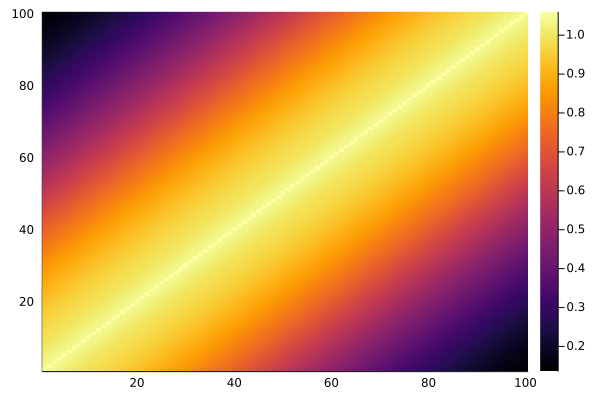

In [7]:
heatmap(cov(f, x) + σ²_n * I)

As such samples can be drawn from it, and the log probability any particular value under
it can be computed, in the same way that you would an `MvNormal` from
[Distributions.jl](https://github.com/JuliaStats/Distributions.jl).

We can visualise `x` and `y` with [Plots.jl](https://github.com/JuliaPlots/Plots.jl)

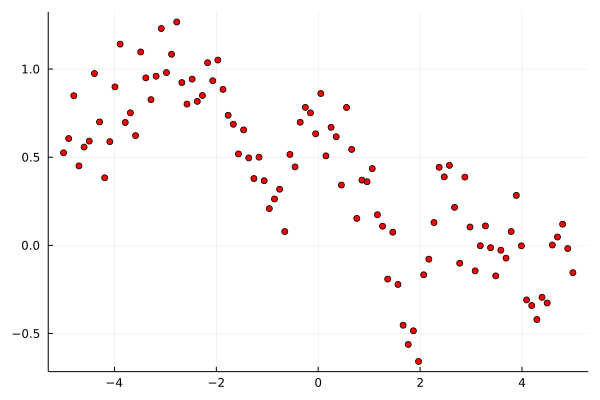

In [8]:
plt = plot();
scatter!(plt, x.x, y; color=:red, label="");
display(plt)

It's straightforward to compute the posterior over `f`:

In [9]:
f_posterior = posterior(fx, y);

`f_posterior` is another GP, the posterior over `f` given noisy observations `y` at inputs `x`.

The plotting recipes from AbstractGPs.jl can be utilised to easily print whichever
component of the GPPP is needed.

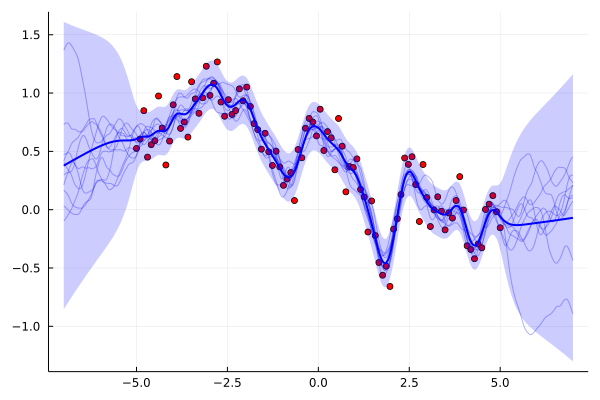

In [10]:
x_plot = range(-7.0, 7.0; length=1000);
xp = GPPPInput(:f3, x_plot);
plot!(
    plt, x_plot, f_posterior(xp);
    ribbon_scale=3, label="", color=:blue, fillalpha=0.2, linewidth=2,
)
plot!(
    plt, x_plot, rand(f_posterior(xp, 1e-9), 10);
    samples=10, markersize=1, alpha=0.3, label="", color=:blue,
);
plt

So you've built a simple GP probabilistic programme, performed inference in it, and
looked at the posterior.
We've only looked at one component of it though -- we could look at others.
Consider `f2`:

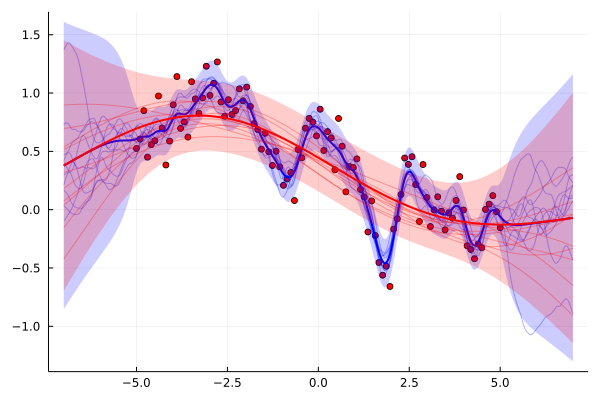

In [11]:
xp2 = GPPPInput(:f2, x_plot);
plot!(
    plt, x_plot, f_posterior(xp2);
    ribbon_scale=3, label="", color=:red, fillalpha=0.2, linewidth=2,
);
plot!(
    plt, x_plot, rand(f_posterior(xp2, 1e-9), 10);
    alpha=0.3, label="", color=:red,
);
plt

## Fit a GP with NelderMead in 2 Minutes

Stheno.jl is slightly unusual in that it declines to provide a `fit` or `train` function. Why is this? In short, because there's really no need -- the ecosystem now contains everything that is needed to easily do this yourself. By declining to insist on an interface, Stheno.jl is able to interact with a wide array of tools, that you can use in whichever way you please.

Optim requires that you provide an objective function with a single `Vector{<:Real}` parameter for most of its optimisers.
We'll use ParameterHandling.jl to build one of these in a way that doesn't involve manually writing code to convert between a structured, human-readable, representation of our parameters (in a `NamedTuple`) and a `Vector{Float64}`.

First, we'll put the model from before into a function:

In [12]:
function build_model(θ::NamedTuple)
    return @gppp let
        f1 = θ.s1 * stretch(GP(SEKernel()), 1 / θ.l1)
        f2 = θ.s2 * stretch(GP(SEKernel()), 1 / θ.l2)
        f3 = f1 + f2
    end
end

build_model (generic function with 1 method)

We've assumed that the parameters will be provided as a `NamedTuple`, so let's build one and check that the model can be constructed:

In [13]:
using ParameterHandling

θ = (
    # Short length-scale and small variance.
    l1 = positive(0.4),
    s1 = positive(0.2),

    # Long length-scale and larger variance.
    l2 = positive(5.0),
    s2 = positive(1.0),

    # Observation noise variance -- we'll be learning this as well.
    s_noise = positive(0.1),
)

(l1 = ParameterHandling.Positive{Float64, Bijectors.Exp{0}, Float64}(-0.9162907691270586, Bijectors.Exp{0}(), 1.4901161193847656e-8), s1 = ParameterHandling.Positive{Float64, Bijectors.Exp{0}, Float64}(-1.6094379869399091, Bijectors.Exp{0}(), 1.4901161193847656e-8), l2 = ParameterHandling.Positive{Float64, Bijectors.Exp{0}, Float64}(1.6094379094538682, Bijectors.Exp{0}(), 1.4901161193847656e-8), s2 = ParameterHandling.Positive{Float64, Bijectors.Exp{0}, Float64}(-1.490116130486996e-8, Bijectors.Exp{0}(), 1.4901161193847656e-8), s_noise = ParameterHandling.Positive{Float64, Bijectors.Exp{0}, Float64}(-2.3025852420056685, Bijectors.Exp{0}(), 1.4901161193847656e-8))

We've used `ParameterHandling.jl`s `positive` constraint to ensure that all of the
parameters remain positive during optimisation.
Note that there's no magic here, and `Optim` knows nothing about `positive`.
Rather, `ParameterHandling` knows how to make sure that `Optim` will optimise the log of
the parameters which we want to be positive.

We can make this happen with the following:

In [14]:
using ParameterHandling
using ParameterHandling: value, flatten

θ_flat_init, unflatten = flatten(θ);

Concrete types used for clarity only.

In [15]:
unpack = value ∘ unflatten;

We can now easily define a function which accepts the flat form of the parameters, and
return the negative log marginal likelihood (nlml) of the parameters θ:

In [16]:
function nlml(θ::NamedTuple)
    f = build_model(θ)
    return -logpdf(f(x, θ.s_noise + 1e-6), y)
end

nlml (generic function with 1 method)

We can use any gradient-free optimisation technique from
[Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) to find the parameters whose
negative log marginal likelihood is locally minimal:

In [17]:
using Optim
results = Optim.optimize(
    nlml ∘ unpack,
    θ_flat_init + randn(length(θ_flat_init)),
    NelderMead(),
)
θ_opt = unpack(results.minimizer);

Note that we just added some noise to the initial values to make the optimisation more
interesting.

We can now use this to construct the posterior GP and look at the posterior in comparison
to the true posterior with the known hyperparameters

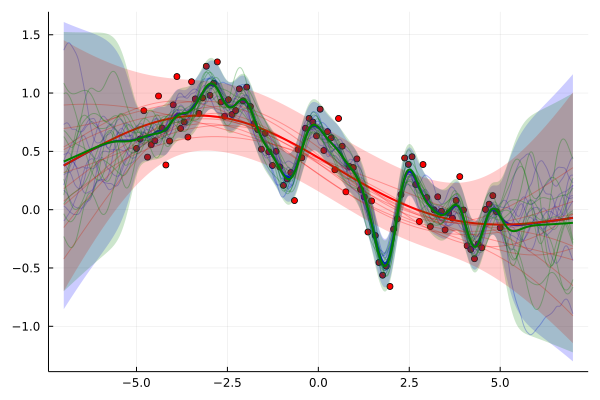

In [18]:
f_opt = build_model(θ_opt);
f_posterior_opt = posterior(f_opt(x, θ_opt.s_noise), y);
ms_opt = marginals(f_posterior_opt(xp));
plot!(
    plt, x_plot, mean.(ms_opt);
    ribbon=3std.(ms_opt), label="", color=:green, fillalpha=0.2, linewidth=2,
);
plot!(
    plt, x_plot, rand(f_posterior_opt(xp, 1e-9), 10);
    alpha=0.3, label="", color=:green,
);
plt

Of course, the exact posterior has not been recovered because the exact hyperparameters
cannot be expected to be recovered given a finite amount of data over a finite width
window.

## Fit a GP with BFGS in 2 minutes

The BFGS algorithm is generally the preferred choice when optimising the hyperparameters
of fairly simple GPs. It requires access to the gradient of our `nlml` function, which
can be straightforwardly obtained via reverse-mode algorithmic differentiation, which is
provided by [Zygote.jl](https://github.com/FluxML/Zygote.jl):

In [19]:
using Zygote: gradient

This will probably take a while to get going as Zygote needs to compile.

In [20]:
results = Optim.optimize(
    nlml ∘ unpack,
    θ->gradient(nlml ∘ unpack, θ)[1],
    θ_flat_init + 0.1 * randn(length(θ_flat_init)),
    BFGS(),
    Optim.Options(
        show_trace=true,
    );
    inplace=false,
)
θ_bfgs = unpack(results.minimizer);

Iter     Function value   Gradient norm 
     0     1.841583e+01     3.215549e+01
 * time: 0.00010204315185546875
     1     1.958971e+00     2.460399e+01
 * time: 0.027512073516845703
     2    -1.462754e+00     2.251534e+01
 * time: 0.04689502716064453
     3    -4.964482e+00     2.400498e+01
 * time: 0.06608891487121582
     4    -5.995899e+00     2.237949e+01
 * time: 0.07856512069702148
     5    -6.323732e+00     1.752010e+01
 * time: 0.09066009521484375
     6    -9.355934e+00     5.361802e+00
 * time: 0.1031351089477539
     7    -1.208391e+01     3.821313e+00
 * time: 0.12674999237060547
     8    -1.244803e+01     2.949612e+00
 * time: 0.1401200294494629
     9    -1.363892e+01     2.113601e+00
 * time: 0.1923689842224121
    10    -1.386151e+01     1.885481e+00
 * time: 0.21773195266723633
    11    -1.401264e+01     1.013439e+00
 * time: 0.23112702369689941
    12    -1.406592e+01     8.863059e-01
 * time: 0.24328994750976562
    13    -1.408367e+01     4.763831e-01
 * time

Once more visualising the results:

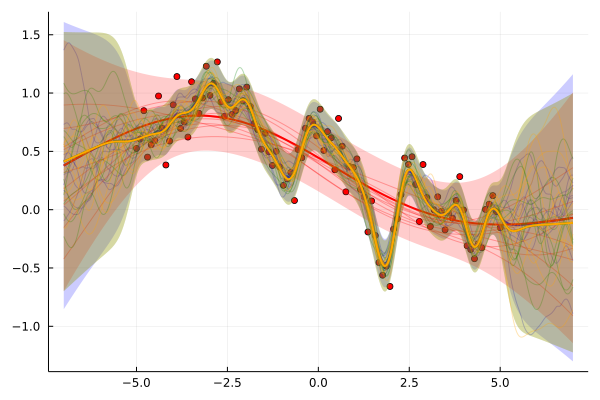

In [21]:
f_bfgs = build_model(θ_bfgs);
f_posterior_bfgs = posterior(f_bfgs(x, θ_bfgs.s_noise), y);
ms_bfgs = marginals(f_posterior_bfgs(xp));
plot!(
    plt, x_plot, mean.(ms_bfgs);
    ribbon=3std.(ms_bfgs), label="", color=:orange, fillalpha=0.2, linewidth=2,
);
plot!(
    plt, x_plot, rand(f_posterior_bfgs(xp, 1e-9), 10);
    alpha=0.3, label="", color=:orange,
);
plt

Notice that the two optimisers produce (almost) indistinguishable results.

## Inference with NUTS in 2 minutes

[AdvancedHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl/) provides a
state-of-the-art implementation of the No-U-Turns sampler, which we can use to perform
approximate Bayesian inference in the hyperparameters of the GP.
This is slightly longer than the previous examples, but it's all set up associated with
AdvancedHMC, which is literally a copy-paste from that package's README:

In [22]:
using AdvancedHMC, Zygote

Define the log marginal joint density function and its gradient

In [23]:
ℓπ(θ_flat) = -nlml(unpack(θ_flat)) - 0.5 * sum(abs2, θ_flat)
function ∂ℓπ∂θ(θ_flat)
    lml, back = Zygote.pullback(ℓπ, θ_flat)
    ∂θ_flat = first(back(1.0))
    return lml, ∂θ_flat
end

∂ℓπ∂θ (generic function with 1 method)

Sampling parameter settings

In [24]:
n_samples, n_adapts = 500, 20

(500, 20)

Perturb the initialisation a little bit.

In [25]:
θ0_flat = θ_flat_init + 0.1 * randn(length(θ_flat_init))

5-element Vector{Float64}:
 -0.6936409909740205
 -1.5554166915359893
  1.5245708949839591
 -0.09393091829198358
 -2.407775205826544

Define metric space, Hamiltonian, sampling method and adaptor

In [26]:
metric = DiagEuclideanMetric(5)
h = Hamiltonian(metric, ℓπ, ∂ℓπ∂θ)
int = Leapfrog(find_good_eps(h, θ0_flat))
prop = NUTS{MultinomialTS, GeneralisedNoUTurn}(int)
adaptor = StanHMCAdaptor(n_adapts, Preconditioner(metric), NesterovDualAveraging(0.8, int.ϵ))

StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.4),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(76, -30), window_splits()
)

Perform inference.

In [27]:
samples, stats = sample(h, prop, θ0_flat, n_samples, adaptor, n_adapts; progress=true)

Sampling  0%|▏                              |  ETA: 0:00:35
  iterations:                    2
  n_steps:                       1
  is_accept:                     true
  acceptance_rate:               0.0
  log_density:                   -14.344316014083253
  hamiltonian_energy:            16.206907525991912
  hamiltonian_energy_error:      0.0
  max_hamiltonian_energy_error:  5.625897875452875e9
  tree_depth:                    0
  numerical_error:               true
  step_size:                     0.9340412371245262
  nom_step_size:                 0.9340412371245262
  is_adapt:                      true














Sampling  1%|▎                              |  ETA: 0:00:39
  iterations:                    4
  n_steps:                       15
  is_accept:                     true
  acceptance_rate:               0.9991365083369137
  log_density:                   0.3235625299591103
  hamiltonian_energy:            1.3778129094224743
  hamiltonian_energy_error:      -0.0285774292

([[-0.6936409909740205, -1.5554166915359893, 1.5245708949839591, -0.09393091829198358, -2.407775205826544], [-0.6936409909740205, -1.5554166915359893, 1.5245708949839591, -0.09393091829198358, -2.407775205826544], [-0.6884874494581253, -1.1652386588659998, 1.3576925037119272, 0.20133263513674982, -3.234881842165401], [-1.512133654873614, -1.44316616770972, 1.5882988738163548, -0.31994042325724004, -3.9629664493958994], [-1.1809848309180007, -1.1493937327804962, 1.6846833333773898, -0.13975669628773996, -4.078617936900996], [-1.2871227960256477, -1.6147992028657385, 1.487498646542322, -0.3287971459975859, -4.000487468786935], [-1.0955850129704694, -1.1630815457008254, 1.1946799112677036, 0.5360498768328611, -3.6626603381708085], [-1.0735772555037717, -1.522883556946442, 1.5121821344640325, 0.5471112604652644, -3.429759430531079], [-0.7913919915179414, -1.2286494866328945, 0.5720309218443825, -1.662723142354572, -3.390703127843444], [-0.7913919915179414, -1.2286494866328945, 0.5720309218

Inspect posterior distribution over hyperparameters.

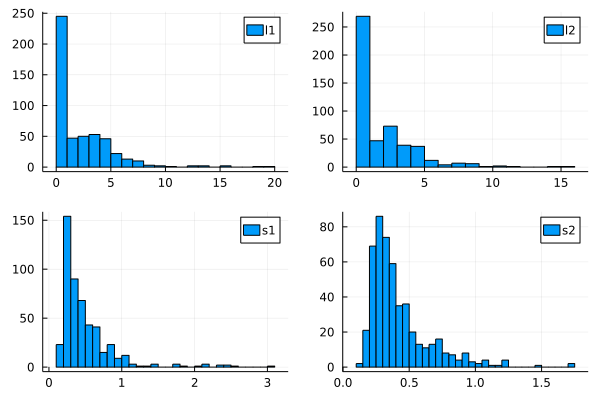

In [28]:
hypers = map(unpack, samples);
h_l1 = histogram(getindex.(hypers, :l1); label="l1");
h_l2 = histogram(getindex.(hypers, :l2); label="l2");
h_s1 = histogram(getindex.(hypers, :s1); label="s1");
h_s2 = histogram(getindex.(hypers, :s2); label="s2");
plot(h_l1, h_l2, h_s1, h_s2; layout=(2, 2))

As expected, the sampler converges to the posterior distribution quickly.
One could combine this code with that from the previous sections to make predictions under
the posterior over the hyperparameters.

## Conclusion

So you now know how to fit GPs using Stheno.jl, and to investigate their posterior
distributions. It's also straightforward to utilise Stheno.jl inside probabilistic
programming frameworks like Soss.jl and Turing.jl (see examples folder).

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*